# **Sulfonamidamide aryl carbonylation enantioselectivity decision tree regression models**

Scripts used to generate the decision tree regression models for the sulfonamidamide aryl carbonylation enantioselectivity data.

## 0. Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap
import random

from functions.plotting.plot_model import plot_model, get_error_plot, run_loocv, run_5foldcv

import warnings
warnings.filterwarnings("ignore")

/var/folders/q_/pxh8rpm1021bvcmqb5qg17p00000gn/T/ipykernel_39983/3857364378.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# this sets plot style defaults for the whole notebook

paramsscreen = {'backend': 'ps',
            'axes.labelsize': 15,
           'legend.fontsize': 15,
           'xtick.labelsize': 13,
           'ytick.labelsize': 13,
           'axes.titlesize': 16}

plt.rcParams.update(paramsscreen)

## 1. Define path to data and generate dataframe

This loads in the data used for the decision tree regression model used in the manuscript. For simplicity only the features used in the model have been provided and ligands which were determined to be <90% unoxidized have been removed. The column "Set" contains the ligands which were included in the training:test splits.

In [3]:
data_path = Path("modeling_data")

# Leave the CSV file for the dataset you want to use uncommented below
data_file = "sia-data-conformers-dtr.csv"
# data_file = "sia-data-lec-dtr.csv"
# data_file = "sia-data-lecfeats-dtr.csv"

df = pd.read_csv(data_path / data_file, index_col=0)
features = df.drop(columns=["4methylmorpholine_ddg", "Set"])

display(df.head())

,4methylmorpholine_ddg,Cl_NBO_Max_boltz,P_Pd_bond_occ_Avg_boltz,angle_R2P2Cback_boltz,NoPd_P_R1_bond_occ_Min_cmin,Set
Ligand ID,,,,,,
pp000061e-PdCl2,-0.807169,-0.564918,1.858089,107.720381,1.94706,Training
pp000027-PdCl2,0.335006,-0.548787,1.862001,102.065703,1.94741,Training
pp000016e-PdCl2,-1.160092,-0.536463,1.867832,108.707054,1.94858,Training
pp000101-PdCl2,0.521337,-0.563175,1.856546,103.654623,1.94856,Training
pp000006-PdCl2,0.882893,-0.558264,1.861231,102.296036,1.94703,Training


## 2. Data distribution analysis

First define the training and test split based on the "Set" column. This was originally determined with: `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)` as implemented in scikit-learn.

In [4]:
X_train = df[df["Set"] == "Training"].drop(columns=["4methylmorpholine_ddg", "Set"])
X_test = df[df["Set"] == "Test"].drop(columns=["4methylmorpholine_ddg", "Set"])
y_train = df[df["Set"] == "Training"]["4methylmorpholine_ddg"]
y_test = df[df["Set"] == "Test"]["4methylmorpholine_ddg"]

Plot histograms of training and test sets.

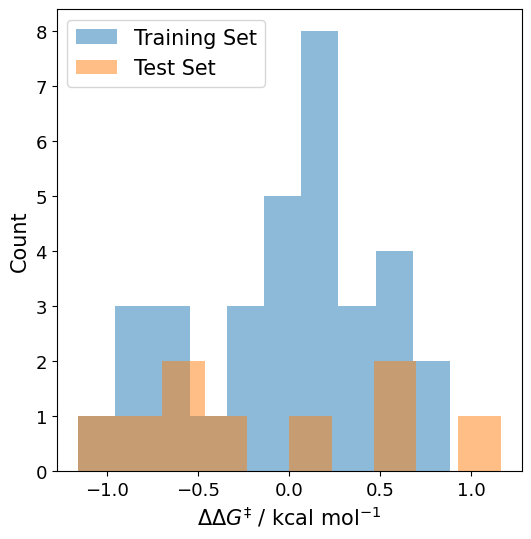

In [5]:
plt.figure(figsize=(6, 6))
plt.hist(y_train, label="Training Set", alpha=0.5)
plt.hist(y_test, label="Test Set", alpha=0.5)
plt.xlabel("$\Delta \Delta G ^{\u2021}$ / kcal mol$^{-1}$")
plt.ylabel("Count")
plt.legend()
plt.show()

## 3. Tune model hyperparameters.

Tuning model hyperparameters using a randomized CV grid search using the training data. These hyperparameters were further tuned by examining the effects of each on the modeling statistics below (Section x).

In [ ]:
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
}

# set up the decision tree regressor
dt = DecisionTreeRegressor(random_state=10)
# set up the randomized search CV
rf_random = RandomizedSearchCV(estimator=dt, 
                                     param_distributions=param_grid, 
                                     n_iter=50, 
                                     cv=5, 
                                     verbose=1, 
                                     random_state=10, 
                                     n_jobs=-1,
                                     scoring='neg_root_mean_squared_error')
# fit the randomized search CV
rf_random.fit(X_train, y_train)

# print the best parameters
print("Best parameters found: ", rf_random.best_params_)

## 4. Run decision tree regression model

There are two `DecisionTreeRegressor` model objects specified. The first is for the conformer-weighted features and the second is for the model generated from scratch from lowest energy conformer features. Users should comment out the appropriate model object below:

In [7]:
dt = DecisionTreeRegressor(min_samples_split=3, min_samples_leaf=2, max_depth=6, random_state=10)  # this for conformer-weighted features
# dt = DecisionTreeRegressor(min_samples_split=5, min_samples_leaf=2, max_depth=7, random_state=10)  # this for lec features

dt.fit(X_train, y_train)
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

Plot model and get statistics.

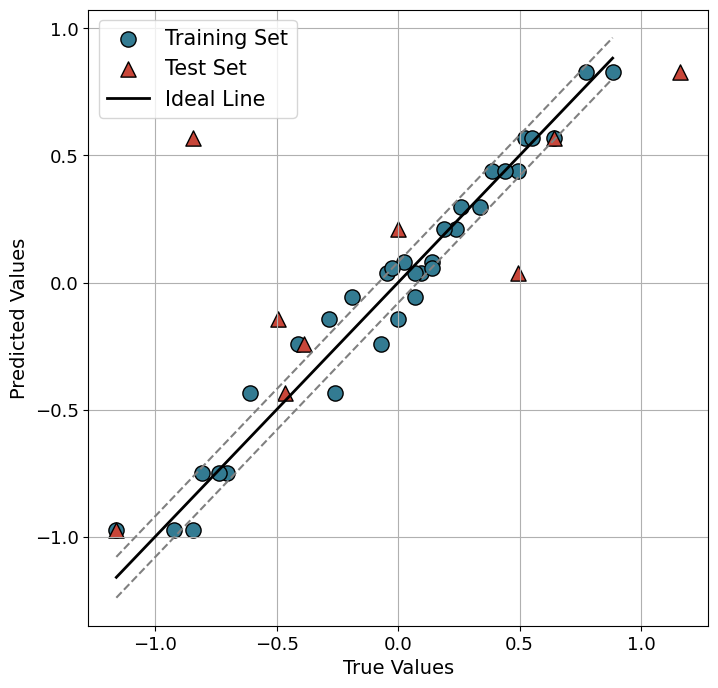

Model Statistics:
Training R²: 0.964
Test R²: 0.449
Training MAE: 0.080
Test MAE: 0.355
Training MSE: 0.009
Test MSE: 0.283
Training RMSE: 0.097
Test RMSE: 0.532


In [8]:
plot_model(y_train, y_test, y_train_pred, y_test_pred)

Get model's decision tree.

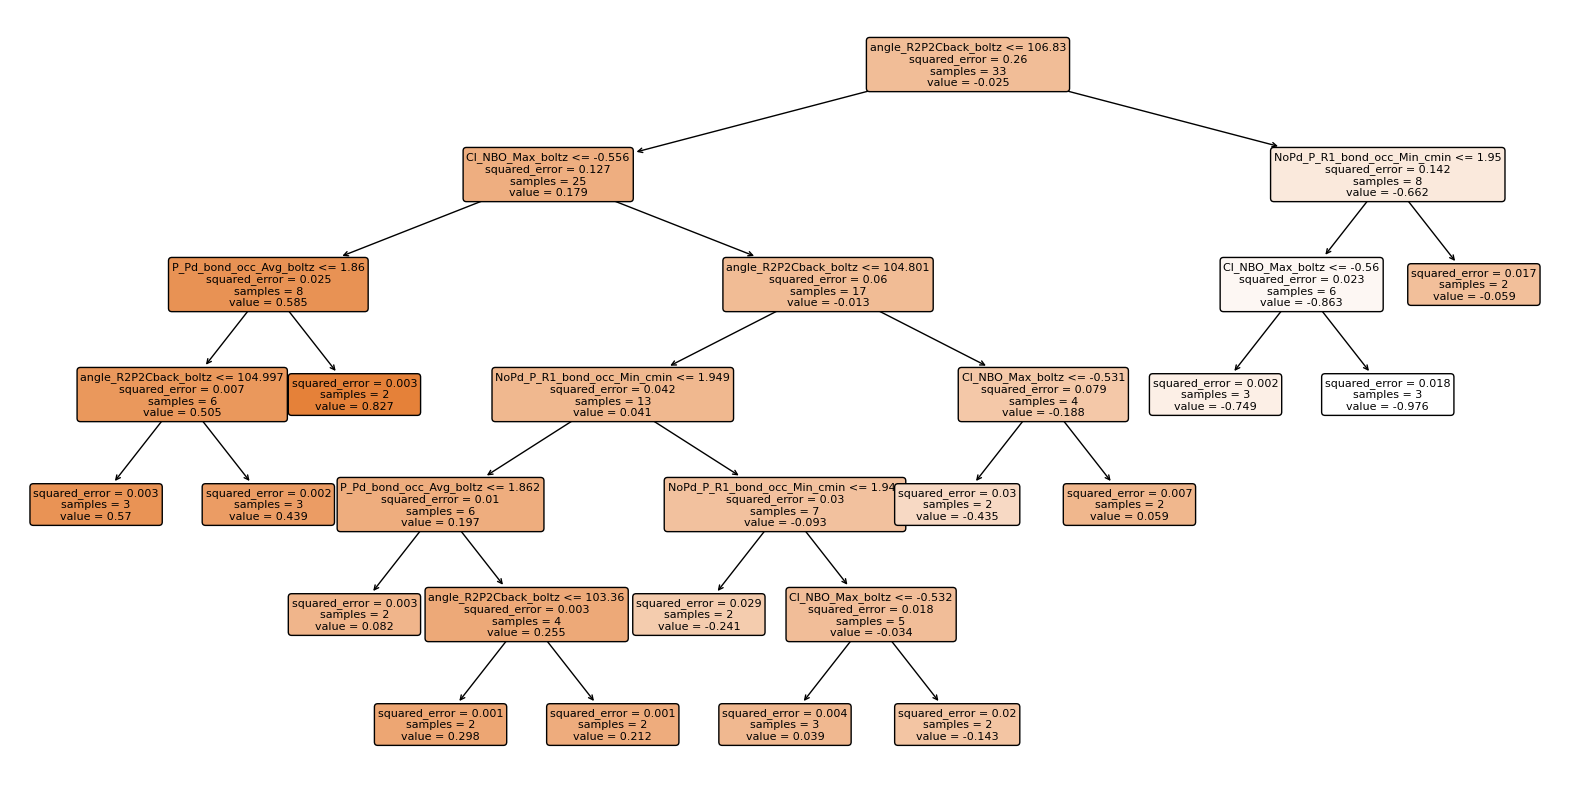

In [9]:
plt.figure(figsize=(20, 10))  # Set the figure size to make the plot larger
plot_tree(dt, filled=True, feature_names=features.columns, rounded=True, fontsize=8)
plt.show()

Find the decision pathway for a given sample. Note that `sample_id` is 0-indexed. This was taken directly from the scikit-learn documentation: [link](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#decision-path).

In [10]:
sample_id = 8

X_test = np.array(X_test)

n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left
children_right = dt.tree_.children_right
feature = dt.tree_.feature
threshold = dt.tree_.threshold
values = dt.tree_.value

node_indicator = dt.decision_path(X_test)
leaf_id = dt.apply(X_test)

# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 8:

decision node 0 : (X_test[8, 2] = 104.162057225358) <= 106.8297119140625)
decision node 1 : (X_test[8, 0] = -0.5574102692688988) <= -0.5560303926467896)
decision node 2 : (X_test[8, 1] = 1.853552899531891) <= 1.8604835867881775)
decision node 3 : (X_test[8, 2] = 104.162057225358) <= 104.99748611450195)


Make model error distribution plot.

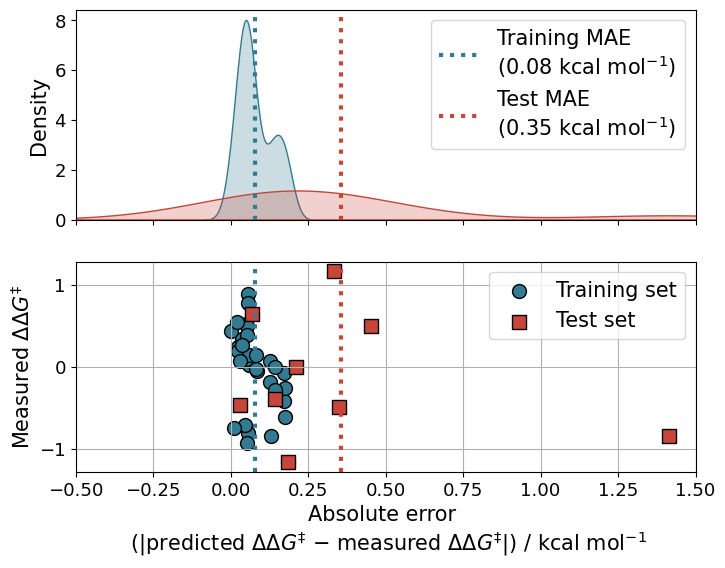

In [11]:
get_error_plot(y_train, y_test, y_train_pred, y_test_pred)

## 5. Feature importance

Uses permutation feature importance and SHAP analysis to determine the feature importance in the decision tree regression model. This uses the test set.

PFI first:

/Users/jamie/opt/anaconda3/envs/bisphos_conf_sel/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/jamie/opt/anaconda3/envs/bisphos_conf_sel/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/jamie/opt/anaconda3/envs/bisphos_conf_sel/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/jamie/opt/anaconda3/envs/bisphos_conf_sel/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/jamie/opt/anaconda3/envs/bisphos_conf_sel/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: 

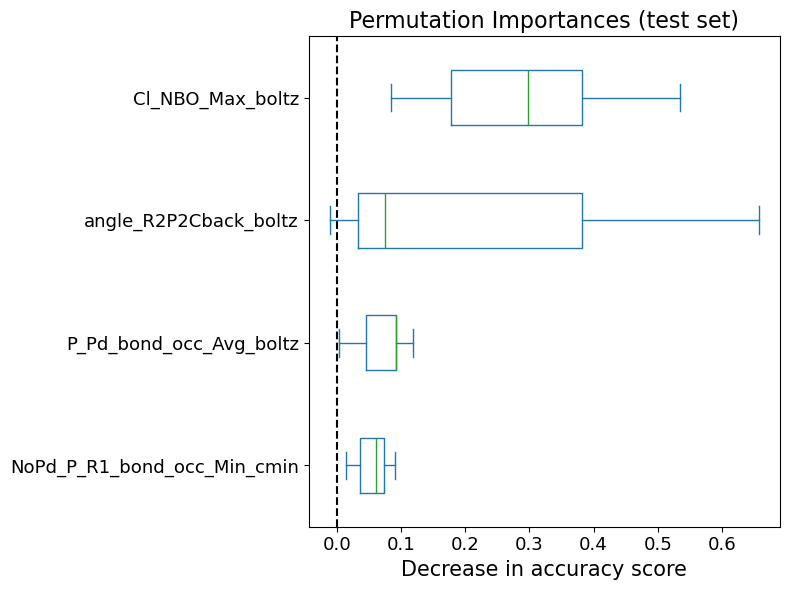

In [12]:
X_labels = features.columns
X_names = X_labels

result = permutation_importance(
    dt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='neg_mean_squared_error'
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_names[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10, figsize=(8, 6))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

SHAP analysis:

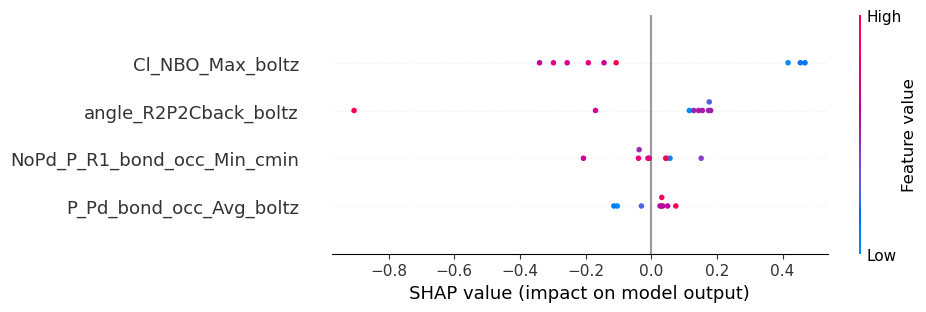

In [13]:
explainer = shap.Explainer(dt.predict, X_test)
shap_values = explainer(X_test)
shap_values.feature_names = list(features.columns)
feature_labels = features.columns

shap.plots.beeswarm(shap_values)

## 6. Checks for overfitting

The following cells show the results of various overfitting checks. The first one is leave-one-out cross-validation analysis.

Leave one out R2: 0.47
Leave one out MAE: 0.32
Leave one out RMSE: 0.32


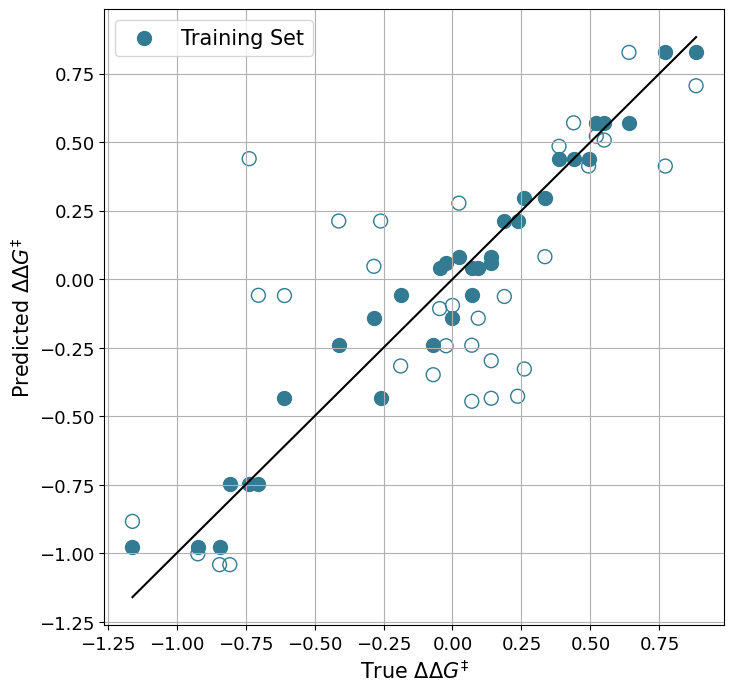

In [17]:
run_loocv(dt, X_train, y_train, y_train_pred)

Next, run the k-fold (5 fold) cross-validation:

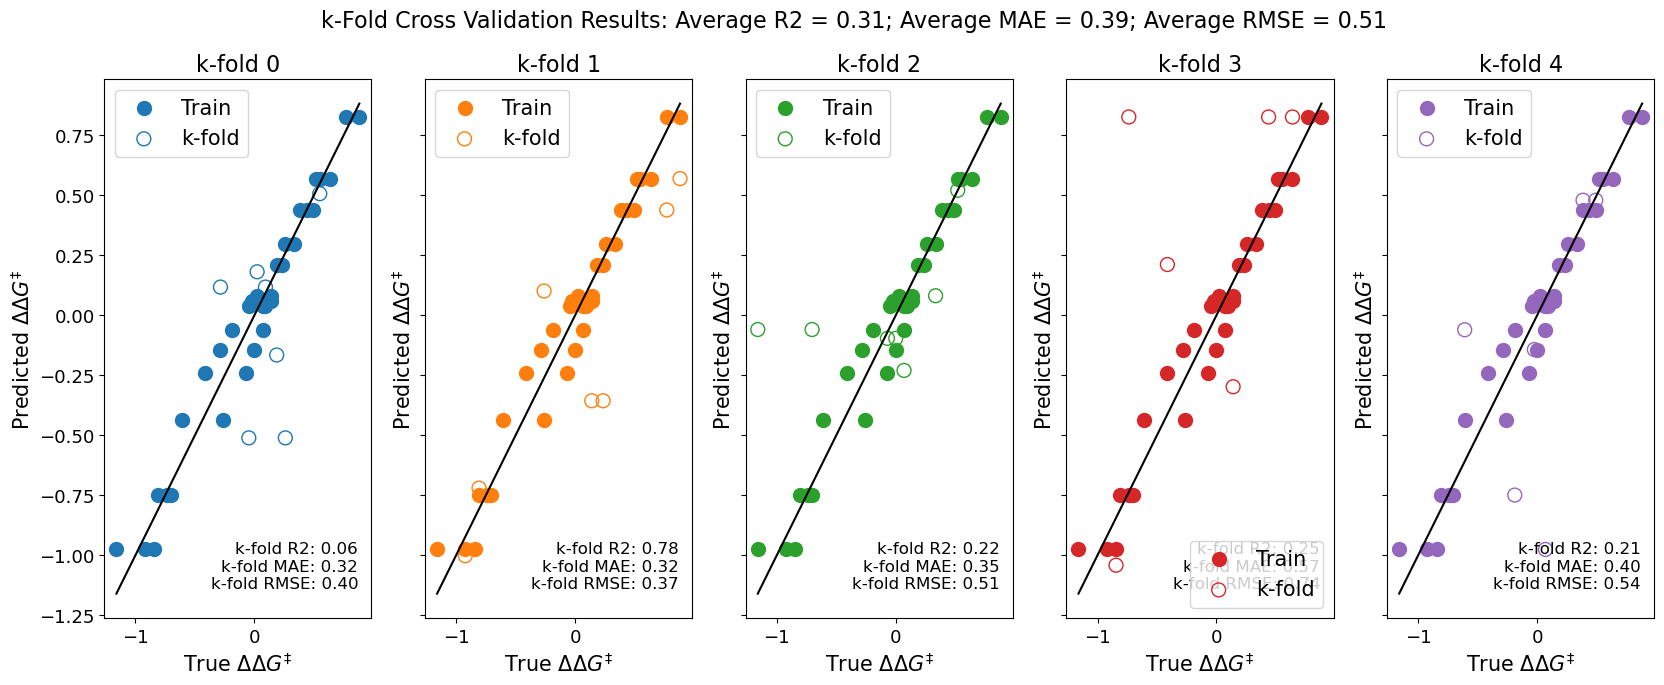

In [18]:
run_5foldcv(dt, X_train, y_train, y_train_pred)

Next the effect of the random state used for generating the training and test sets. Random state selection was performed as follows, for reproducibility, the random states used for the train:test split random state analysis are provided in the following cell.

In [ ]:
random_numbers = [random.randint(1,500) for _ in range(100)]
print(random_numbers)

This analysis uses the `dt` model object defined above. Note that the `X_train` etc. variables are re-assigned here so some of the above cells might not run after performing the following analysis.

In [19]:
random_states = [149, 339, 260, 77, 126, 303, 107, 365, 283, 221, 334, 443, 317, 132, 351, 240, 494, 427, 150, 136, 122, 154, 122, 493, 92, 461, 318, 352, 365, 98, 233, 108, 174, 316, 467, 149, 206, 457, 15, 76, 53, 242, 195, 218, 33, 206, 362, 354, 74, 98, 18, 9, 63, 349, 105, 25, 59, 452, 237, 446, 242, 103, 200, 243, 56, 233, 52, 159, 80, 223, 465, 432, 297, 195, 129, 290, 208, 61, 351, 318, 179, 109, 376, 440, 447, 83, 171, 377, 174, 487, 184, 105, 454, 422, 229, 389, 34, 363, 418, 119]

mses = []
maes = []

X = df.drop(columns=['4methylmorpholine_ddg', 'Set'])
y = df['4methylmorpholine_ddg']

for random_state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mses.append(mse)
    maes.append(mae)

Plot the results.

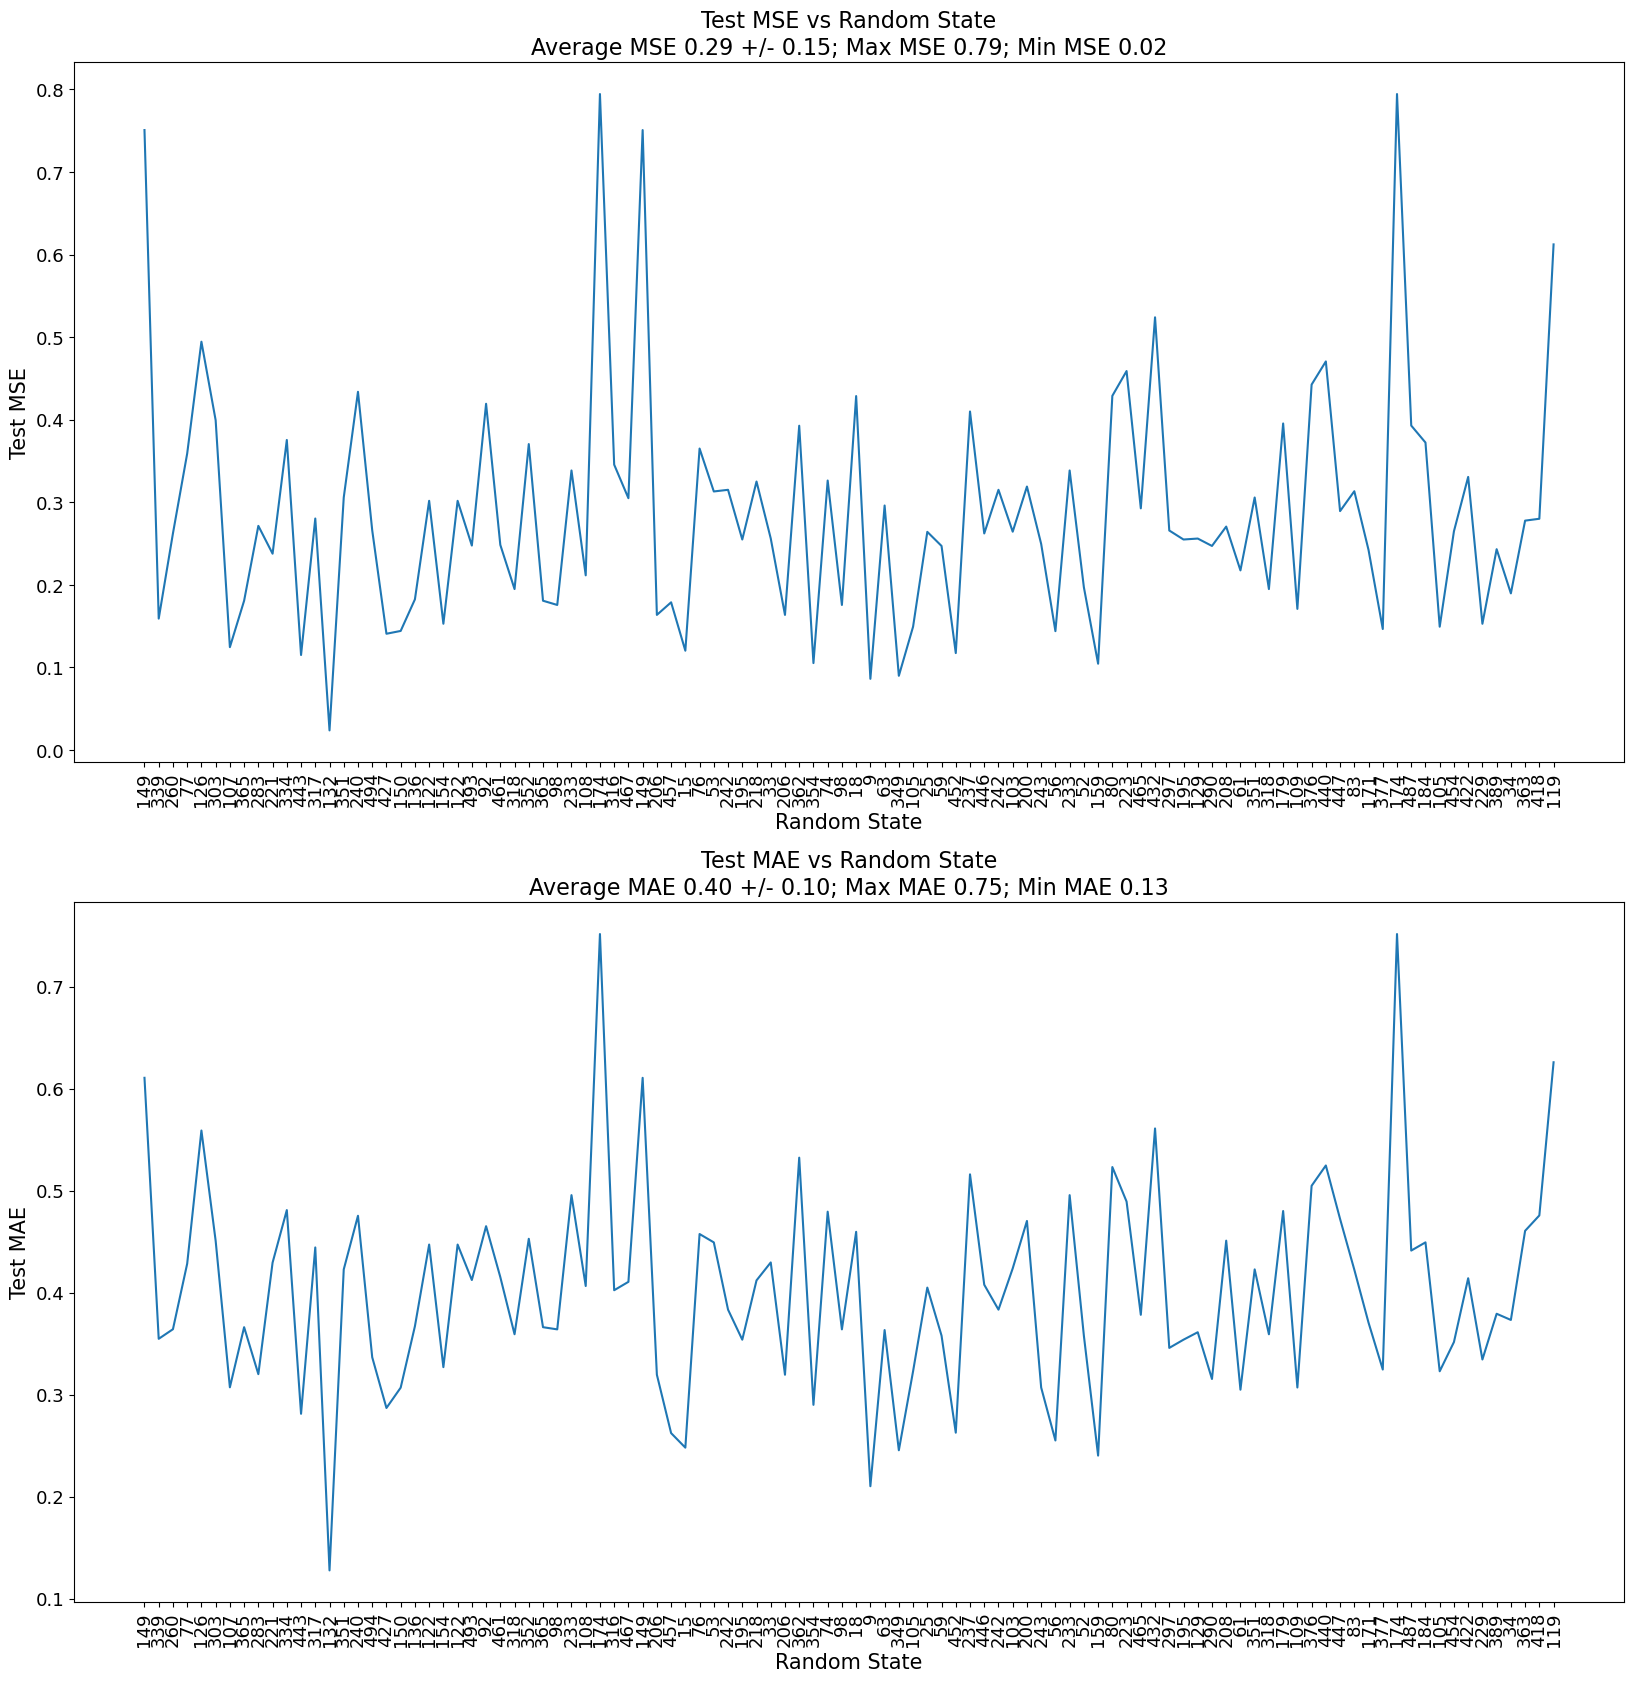

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(20,20))

axs[0].plot(range(len(random_states)), mses)
axs[0].set_xticks(range(len(random_states)), random_states, rotation=90)
axs[0].set_xlabel('Random State')
axs[0].set_ylabel('Test MSE')
axs[0].set_title(f'Test MSE vs Random State\nAverage MSE {np.mean(mses):.2f} +/- {np.std(mses):.2f}; Max MSE {np.max(mses):.2f}; Min MSE {np.min(mses):.2f}')

axs[1].plot(range(len(random_states)), maes)
axs[1].set_xticks(range(len(random_states)), random_states, rotation=90)
axs[1].set_xlabel('Random State')
axs[1].set_ylabel('Test MAE')
axs[1].set_title(f'Test MAE vs Random State\nAverage MAE {np.mean(maes):.2f} +/- {np.std(maes):.2f}; Max MAE {np.max(maes):.2f}; Min MAE {np.min(maes):.2f}')

plt.show()

Next, the effect of the train:test split ratio (up to a 50:50 split) was investigated.

In [21]:
test_splits = [0.1, 0.2, 0.3, 0.4, 0.5]

mses = []
maes = []

for test_split in test_splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=10)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mses.append(mse)
    maes.append(mae)

Plot the results.

Text(0.5, 1.0, 'Test MAE vs Test Split\nAverage MAE 0.39 +/- 0.03; Max MAE 0.43; Min MAE 0.36')

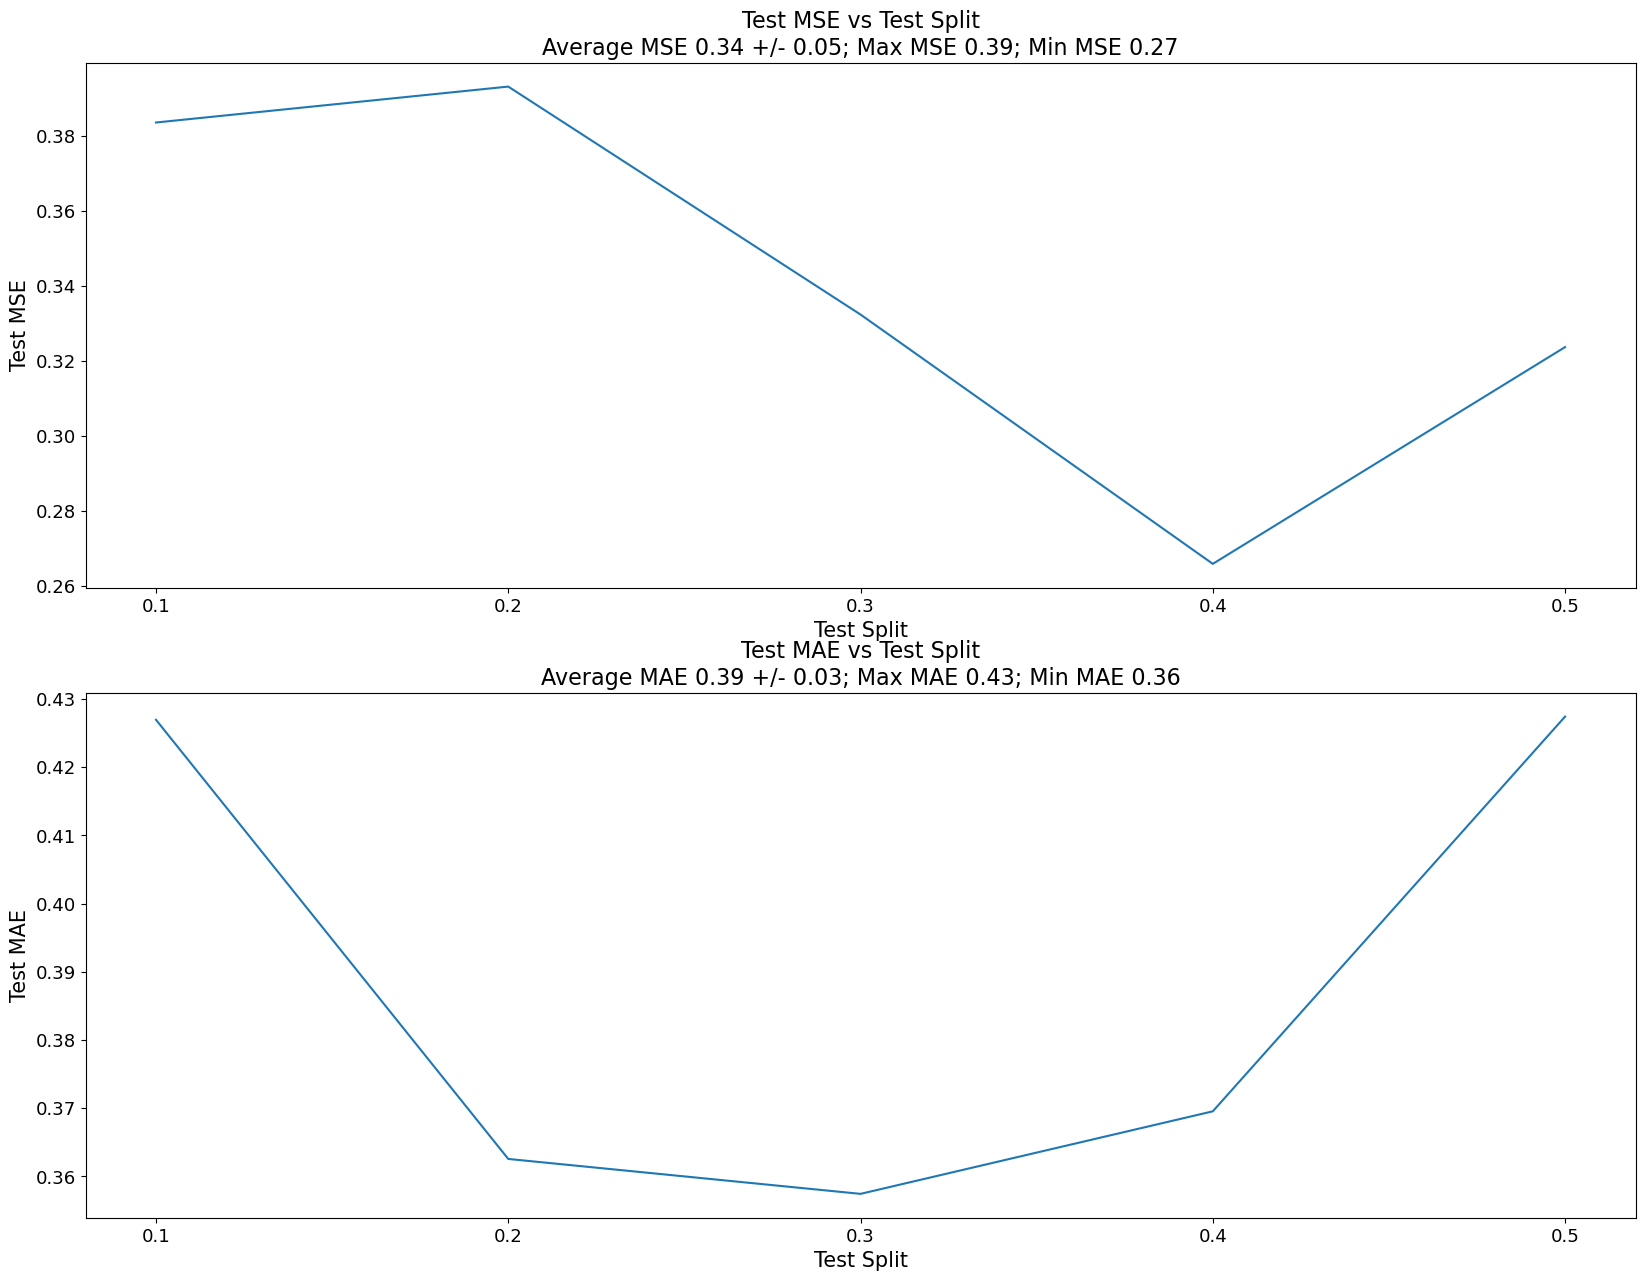

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(20,15))

axs[0].plot(test_splits, mses)
axs[0].set_xticks(test_splits)
axs[0].set_xlabel('Test Split')
axs[0].set_ylabel('Test MSE')
axs[0].set_title(f'Test MSE vs Test Split\nAverage MSE {np.mean(mses):.2f} +/- {np.std(mses):.2f}; Max MSE {np.max(mses):.2f}; Min MSE {np.min(mses):.2f}')

axs[1].plot(test_splits, maes)
axs[1].set_xticks(test_splits)
axs[1].set_xlabel('Test Split')
axs[1].set_ylabel('Test MAE')
axs[1].set_title(f'Test MAE vs Test Split\nAverage MAE {np.mean(maes):.2f} +/- {np.std(maes):.2f}; Max MAE {np.max(maes):.2f}; Min MAE {np.min(maes):.2f}')

## 7. Hyperparameter effects

In this section, the effects of the decision tree regression model's hyperparameters are investigated. Note that you may need to re-define the `X_train`, `y_train` etc. variables at the top of this Jupyter notebook.

First the `max_depth`.

In [23]:
train_maes = {}
test_maes = {}
train_mses = {}
test_mses = {}

max_depths = [2, 3, 4, 5, 6, 7, 8, 9 , 10]

for max_depth in max_depths:
    dt = DecisionTreeRegressor(min_samples_split=3, min_samples_leaf=2, max_depth=max_depth, random_state=10)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    train_maes[max_depth] = mae_train
    test_maes[max_depth] = mae_test
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    train_mses[max_depth] = mse_train
    test_mses[max_depth] = mse_test

Plot the results.

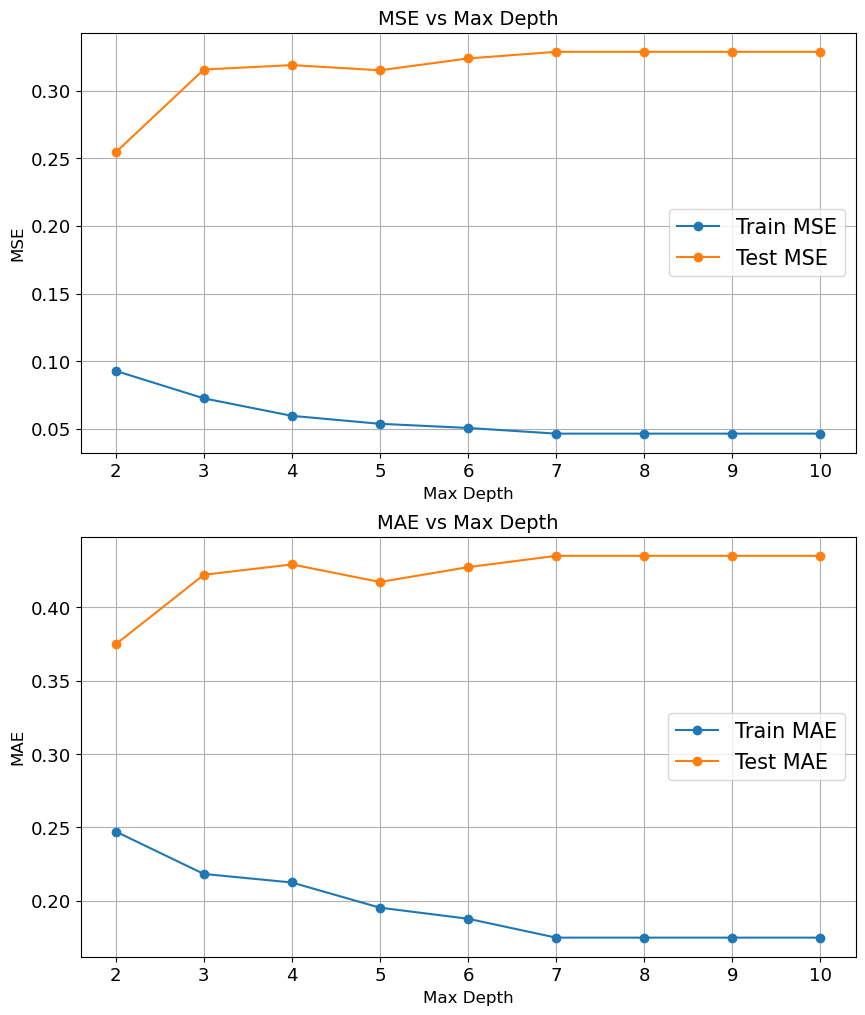

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(max_depths, train_mses.values(), marker='o', label='Train MSE')
axs[0].plot(max_depths, test_mses.values(), marker='o', label='Test MSE')
axs[0].set_xlabel('Max Depth', size=12)
axs[0].set_ylabel('MSE', size=12)
axs[0].legend()
axs[0].set_title('MSE vs Max Depth', size=14)
axs[0].grid()

axs[1].plot(max_depths, train_maes.values(), marker='o', label='Train MAE')
axs[1].plot(max_depths, test_maes.values(), marker='o', label='Test MAE')
axs[1].set_xlabel('Max Depth', size=12)
axs[1].set_ylabel('MAE', size=12)
axs[1].legend()
axs[1].set_title('MAE vs Max Depth', size=14)
axs[1].grid()

Next, `min_samples_leaf`.

In [26]:
train_maes = {}
test_maes = {}
train_mses = {}
test_mses = {}

min_samples_leafs = range(1, 33)

for min_sample_leaf in min_samples_leafs:
    dt = DecisionTreeRegressor(min_samples_split=3, min_samples_leaf=min_sample_leaf, max_depth=5, random_state=10)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    train_maes[min_sample_leaf] = mae_train
    test_maes[min_sample_leaf] = mae_test
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    train_mses[min_sample_leaf] = mse_train
    test_mses[min_sample_leaf] = mse_test

Plot results.

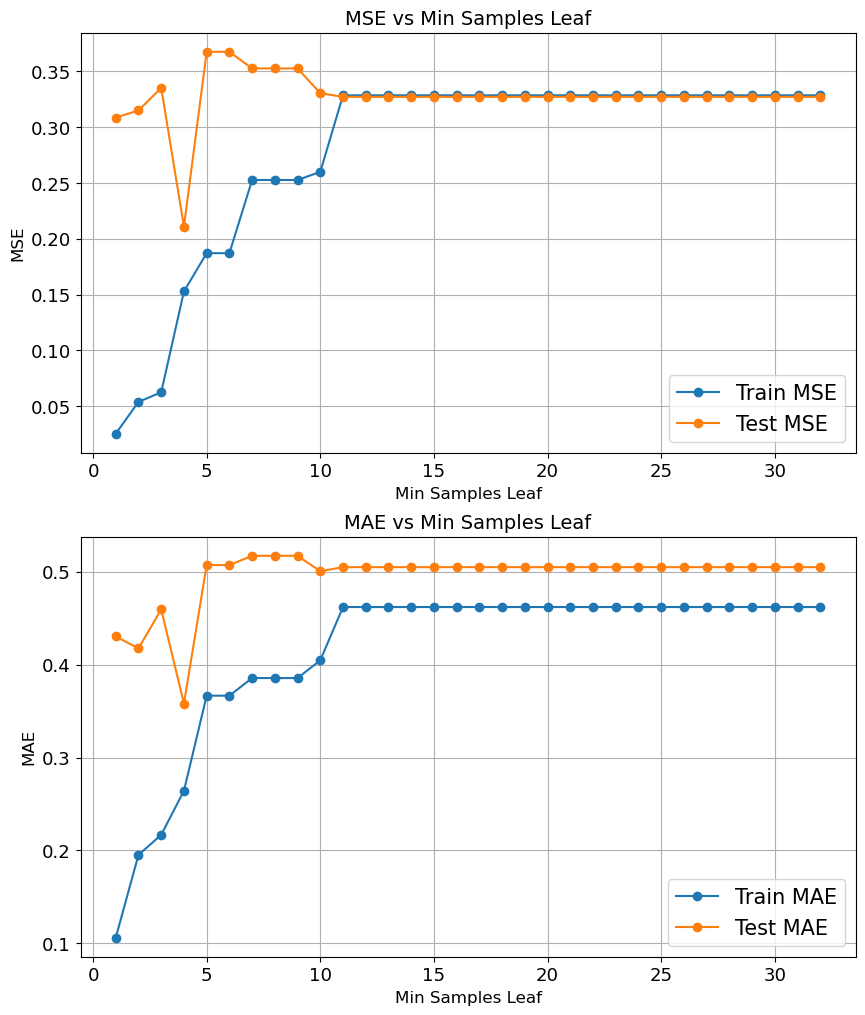

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(min_samples_leafs, train_mses.values(), marker='o', label='Train MSE')
axs[0].plot(min_samples_leafs, test_mses.values(), marker='o', label='Test MSE')
axs[0].set_xlabel('Min Samples Leaf', size=12)
axs[0].set_ylabel('MSE', size=12)
axs[0].legend()
axs[0].set_title('MSE vs Min Samples Leaf', size=14)
axs[0].grid()

axs[1].plot(min_samples_leafs, train_maes.values(), marker='o', label='Train MAE')
axs[1].plot(min_samples_leafs, test_maes.values(), marker='o', label='Test MAE')
axs[1].set_xlabel('Min Samples Leaf', size=12)
axs[1].set_ylabel('MAE', size=12)
axs[1].legend()
axs[1].set_title('MAE vs Min Samples Leaf', size=14)
axs[1].grid()

And lastly, `min_samples_split`.

In [28]:
train_maes = {}
test_maes = {}
train_mses = {}
test_mses = {}

min_samples_splits = range(2, 33)

for min_samples_split in min_samples_splits:
    dt = DecisionTreeRegressor(min_samples_split=min_samples_split, min_samples_leaf=2, max_depth=5, random_state=10)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    train_maes[min_samples_split] = mae_train
    test_maes[min_samples_split] = mae_test
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    train_mses[min_samples_split] = mse_train
    test_mses[min_samples_split] = mse_test

Plot results.

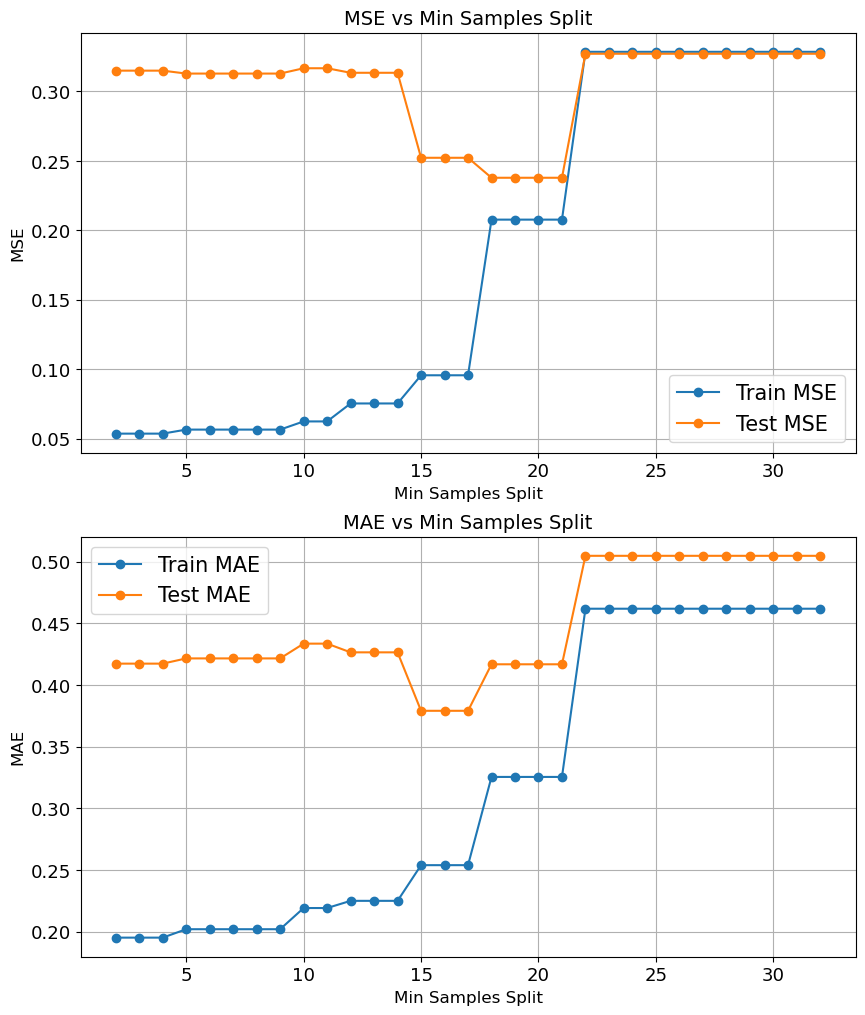

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(min_samples_splits, train_mses.values(), marker='o', label='Train MSE')
axs[0].plot(min_samples_splits, test_mses.values(), marker='o', label='Test MSE')
axs[0].set_xlabel('Min Samples Split', size=12)
axs[0].set_ylabel('MSE', size=12)
axs[0].legend()
axs[0].set_title('MSE vs Min Samples Split', size=14)
axs[0].grid()

axs[1].plot(min_samples_splits, train_maes.values(), marker='o', label='Train MAE')
axs[1].plot(min_samples_splits, test_maes.values(), marker='o', label='Test MAE')
axs[1].set_xlabel('Min Samples Split', size=12)
axs[1].set_ylabel('MAE', size=12)
axs[1].legend()
axs[1].set_title('MAE vs Min Samples Split', size=14)
axs[1].grid()